# **LIBRARIES**

In [1]:
import os
import gc
import time
import numpy as np
import pandas as pd
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from glob import glob
from pathlib import Path
from datetime import datetime
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve, auc
from tqdm.notebook import tqdm
import joblib
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


# **CONFIGURATION**

In [2]:
# GENERAL CONFIGURATIONS
NUM_THREADS = 4
DATA_DIRECTORY = "/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/"
SUBMISSION_SUFIX = "_model2_0"
# LIGHTGBM CONFIGURATION AND HYPER-PARAMETERS
GENERATE_SUBMISSION_FILES = True
EVALUATE_VALIDATION_SET = True
SHOW_REPORT = True
STRATIFIED_KFOLD = True
RANDOM_SEED = 737851
NUM_FOLDS = 10
EARLY_STOPPING = 100
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")

LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'n_estimators': 1000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1,
    
}

### Set aggregations

In [3]:
# AGGREGATIONS

# D: max, min, mean
# M: 
# A : max, min, mean, sum
# L : max, min, mean, sum


APPLPREV1_AGG = {

    'num_group1':['count'],
    'actualdpd_943P': ['min','max','mean','sum'],
    'annuity_853A': ['min','max','mean','sum'],
    'approvaldate_319D':['max','min','mean'],
    'byoccupationinc_3656910L': ['min','max','mean','sum'],
    'cancelreason_3545846M':['max'],
    'childnum_21L': ['min','max','mean','sum'],
    'creationdate_885D':['min','max','mean'],
    #'credacc_actualbalance_314A': ['min','max','mean','sum'],
    'credacc_credlmt_575A': ['min','max','mean','sum'],
    'credacc_maxhisbal_375A': ['min','max','mean','sum'],
    'credacc_minhisbal_90A': ['min','max','mean','sum'],
    #'credacc_status_367L': ['min','max','mean','sum'],
    'credacc_transactions_402L': ['min','max','mean','sum'],
    'credamount_590A': ['min','max','mean','sum'],
    'credtype_587L': ['max'],
    'currdebt_94A': ['min','max','mean','sum'],
    'dateactivated_425D':['min','max','mean'],
    #'district_544M':['max'],
    'downpmt_134A': ['min','max','mean','sum'],
    'dtlastpmt_581D':['min','max','mean'],
    'dtlastpmtallstes_3545839D':['min','max','mean'],
    'education_1138M':['max'],
    'employedfrom_700D':['min','max','mean'],
    'familystate_726L': ['max'],
    'firstnonzeroinstldate_307D': ['min','max','mean'],
    'inittransactioncode_279L': ['max'],
    'isbidproduct_390L': ['min','max','mean','sum'],
    'isdebitcard_527L': ['min','max','mean','sum'],
    'mainoccupationinc_437A': ['min','max','mean','sum'],
    'maxdpdtolerance_577P': ['min','max','mean','sum'],
    'outstandingdebt_522A': ['min','max','mean','sum'],
    'pmtnum_8L': ['min','max','mean','sum'],
    'postype_4733339M':['max'],
    #'profession_152M':['max'],
    'rejectreason_755M':['max'],
    'rejectreasonclient_4145042M':['max'],
    'revolvingaccount_394A': ['min','max','mean','sum'],
    'status_219L': ['max'],
    'tenor_203L': ['min','max','mean','sum'],
    
    
    
}
APPLPREV2_AGG = {
    'num_group1':['count']
    
}
PERSON1_AGG={
    'num_group1':['count'],
    'birth_259D': ['max'],
    
    'childnum_185L':['max','mean','min'],
    
    'contaddr_district_15M':['max','mean','min'],
    'contaddr_matchlist_1032L':['max','mean','min'],
    
    'education_927M':['max','mean','min'],
    
    
    'empl_employedfrom_271D':['max','mean','min'],
    'incometype_1044T':['max','min','mean'],
    'mainoccupationinc_384A':['min','max','mean','count','sum'],
    'relationshiptoclient_415T':['max','min','mean'],
    'relationshiptoclient_642T':['max','mean','min'],
    'language1_981M':['min','max'],
    'familystate_447L':['max','min','mean'],
    'sex_738L':['max','min','mean'],
    
    
    
}
PERSON2_AGG={
    'num_group1':['count']
}
OTHER_AGG={
    'num_group1':['count']
}
DEBITCARD_AGG={
    'num_group1':['count']
}
TAX_REGISTRY_A_AGG={
    'amount_4527230A': ['max','mean','min'],
    'num_group1':['count']
    
}
TAX_REGISTRY_B_AGG={
    
    'amount_4917619A':['min','mean','max'],
    'num_group1':['count']
}
TAX_REGISTRY_C_AGG={
    
    'pmtamount_36A':['min','mean','max'],
    'processingdate_168D':['mean','min','max'],
    'num_group1':['count']
}
CREDIT_BUREAU_A_1_AGG={
    
    'overdueamountmaxdatemonth_365T':['min','max','mean','count','sum'],
    'num_group1':['min','max','mean','count','sum'],
    'dpdmax_757P':['min','max','mean','count','sum'],
    'instlamount_768A':['min','max','mean','count','sum'],
    'outstandingamount_362A':['min','max','mean','count','sum'],
    'overdueamount_31A':['min','max','mean','count','sum'],
    'overdueamount_659A':['min','max','mean','count','sum']
    
}
CREDIT_BUREAU_B_1_AGG={
    'num_group1':['min','max','mean','count','sum']
}
CREDIT_BUREAU_A_2_AGG={
    
    'collater_valueofguarantee_1124L':['min','max','mean','count','sum'],
    'collater_valueofguarantee_876L':['min','max','mean','count','sum'],
    'pmts_year_1139T':['min','max','mean','count','sum'],
    'pmts_overdue_1152A':['min','max','mean','count','sum'],
    
    
    'num_group1':['min','max','mean','count','sum'],
    'num_group2':['min','max','mean','count','sum']
}
CREDIT_BUREAU_B_2_AGG={
    'num_group1':['count']
}


# **MAIN FUNCTION**

In [4]:
def main(debug= False):
    num_rows = 11111 if debug else None
    with timer("base"):
        
        df = get_base(DATA_DIRECTORY, num_rows=num_rows)
        #df=df.to_pandas()
        print("base dataframe shape:", df.shape)
        #df=reduce_mem_usage(df)
        
        
    with timer("static"):
       
        df_static = get_static(DATA_DIRECTORY, num_rows=num_rows)
        df = df.join(df_static, on='case_id', how='left', suffix='_static')
        print("static dataframe shape:", df_static.shape)
        print("DATAFRAME shape:", df.shape)
        
        del df_static
        gc.collect()

    with timer("static_cb"):
       
        df_static_cb = get_static_cb(DATA_DIRECTORY, num_rows=num_rows)
        df = df.join(df_static_cb, on='case_id', how='left', suffix='_static_cb')
        print("static cb dataframe shape:", df_static_cb.shape)
        print("DATAFRAME shape:", df.shape)
        del df_static_cb
        gc.collect()

    with timer("Previous applications depth 1 test"):
       
        df_applprev1 = get_applprev1(DATA_DIRECTORY, num_rows=num_rows)
        df_applprev1 = df_applprev1.filter(pl.col('case_id').is_in(df['case_id'].unique()))
        df = df.join(df_applprev1, on='case_id', how='left', suffix='_applprev1')
        print("Previous applications depth 1 test dataframe shape:", df_applprev1.shape)
        print("DATAFRAME shape:", df.shape)
        del df_applprev1
        gc.collect()

    with timer("Previous applications depth 2 test"):
       
        df_applprev2 = get_applprev2(DATA_DIRECTORY, num_rows=num_rows)
        df_applprev2 = df_applprev2.filter(pl.col('case_id').is_in(df['case_id'].unique()))
        df = df.join(df_applprev2, on='case_id', how='left', suffix='_applprev2')
        print("Previous applications depth 2 test dataframe shape:", df_applprev2.shape)
        print("DATAFRAME shape:", df.shape)
        del df_applprev2
        gc.collect()

    with timer("Person depth 1 test"):
       
        df_person1 = get_person1(DATA_DIRECTORY, num_rows=num_rows)
        df_person1 = df_person1.filter(pl.col('case_id').is_in(df['case_id'].unique()))
        df = df.join(df_person1, on='case_id', how='left', suffix='_person1')
        print("Person depth 1 test dataframe shape:", df_person1.shape)
        print("DATAFRAME shape:", df.shape)
        del df_person1
        gc.collect()

    with timer("Person depth 2 test"):
     
        df_person2 = get_person2(DATA_DIRECTORY, num_rows=num_rows)
        df_person2 = df_person2.filter(pl.col('case_id').is_in(df['case_id'].unique()))
        df = df.join(df_person2, on='case_id', how='left', suffix='_person2')
        print("Person depth 2 test dataframe shape:", df_person2.shape)
        print("DATAFRAME shape:", df.shape)
        del df_person2
        gc.collect()

    with timer("Other test"):
        
        df_other = get_other(DATA_DIRECTORY, num_rows=num_rows)
        df_other = df_other.filter(pl.col('case_id').is_in(df['case_id'].unique()))
        df = df.join(df_other, on='case_id', how='left', suffix='_other')
        print("Other test dataframe shape:", df_other.shape)
        print("DATAFRAME shape:", df.shape)
        del df_other
        gc.collect()

    with timer("Debit card test"):
      
        df_debitcard = get_debitcard(DATA_DIRECTORY, num_rows=num_rows)
        df_debitcard = df_debitcard.filter(pl.col('case_id').is_in(df['case_id'].unique()))
        df = df.join(df_debitcard, on='case_id', how='left', suffix='_debitcard')
        print("Debit card test dataframe shape:", df_debitcard.shape)
        print("DATAFRAME shape:", df.shape)
        del df_debitcard
        gc.collect()

    with timer("Tax registry a test"):
        
        df_tax_registry_a = get_tax_registry_a(DATA_DIRECTORY, num_rows=num_rows)
        df_tax_registry_a = df_tax_registry_a.filter(pl.col('case_id').is_in(df['case_id'].unique()))
        df = df.join(df_tax_registry_a, on='case_id', how='left', suffix='_tax_registry_a')
        print("Tax registry a test dataframe shape:", df_tax_registry_a.shape)
        print("DATAFRAME shape:", df.shape)
        del df_tax_registry_a
        gc.collect()

    with timer("Tax registry b test"):
       
        df_tax_registry_b = get_tax_registry_b(DATA_DIRECTORY, num_rows=num_rows)
        df_tax_registry_b = df_tax_registry_b.filter(pl.col('case_id').is_in(df['case_id'].unique()))
        df = df.join(df_tax_registry_b, on='case_id', how='left', suffix='_tax_registry_b')
        print("Tax registry b test dataframe shape:", df_tax_registry_b.shape)
        print("DATAFRAME shape:", df.shape)
        del df_tax_registry_b
        gc.collect()

    with timer("Tax registry c test"):
        
        df_tax_registry_c = get_tax_registry_c(DATA_DIRECTORY, num_rows=num_rows)
        df_tax_registry_c = df_tax_registry_c.filter(pl.col('case_id').is_in(df['case_id'].unique()))
        df = df.join(df_tax_registry_c, on='case_id', how='left', suffix='_tax_registry_c')
        print("Tax registry c test dataframe shape:", df_tax_registry_c.shape)
        print("DATAFRAME shape:", df.shape)
        del df_tax_registry_c
        gc.collect()
    
        
 
    with timer("Credit bureau a 1 test"):

        df_credit_bureau_a_1 = get_credit_bureau_a_1(DATA_DIRECTORY, num_rows=num_rows)
        df_credit_bureau_a_1 = df_credit_bureau_a_1.filter(pl.col('case_id').is_in(df['case_id'].unique()))
        df = df.join(df_credit_bureau_a_1, on='case_id', how='left', suffix='_cb_a_1')
        print("Credit bureau a 1 test dataframe shape:", df_credit_bureau_a_1.shape)
        print("DATAFRAME shape:", df.shape)
        del df_credit_bureau_a_1
        gc.collect()
    with timer("Credit bureau b 1 test"):
       
        df_credit_bureau_b_1 = get_credit_bureau_b_1(DATA_DIRECTORY, num_rows=num_rows)
        df_credit_bureau_b_1 = df_credit_bureau_b_1.filter(pl.col('case_id').is_in(df['case_id'].unique()))
        df = df.join(df_credit_bureau_b_1, on='case_id', how='left', suffix='_cb_b_1')
        print("Credit bureau b 1 test dataframe shape:", df_credit_bureau_b_1.shape)
        print("DATAFRAME shape:", df.shape)
        del df_credit_bureau_b_1
        gc.collect()


    
    
    with timer("Credit bureau a 2 test"):
       
        df_credit_bureau_a_2 = get_credit_bureau_a_2(DATA_DIRECTORY, num_rows=num_rows)
        df_credit_bureau_a_2 = df_credit_bureau_a_2.filter(pl.col('case_id').is_in(df['case_id'].unique()))
        df = df.join(df_credit_bureau_a_2, on='case_id', how='left', suffix='_cb_a_2')
        print("Credit bureau a 1 test dataframe shape:", df_credit_bureau_a_2.shape)
        print("DATAFRAME shape:", df.shape)
        del df_credit_bureau_a_2
        gc.collect()
    
    with timer("Credit bureau b 2 test"):
       
        df_credit_bureau_b_2 = get_credit_bureau_b_2(DATA_DIRECTORY, num_rows=num_rows)
        df_credit_bureau_b_2 = df_credit_bureau_b_2.filter(pl.col('case_id').is_in(df['case_id'].unique()))
        df = df.join(df_credit_bureau_b_2, on='case_id', how='left', suffix='_cb_b_2')
        print("Credit bureau b 2 test dataframe shape:", df_credit_bureau_b_2.shape)
        print("DATAFRAME shape:", df.shape)
        del df_credit_bureau_b_2
        gc.collect()
    with timer("Feature engineering / preprocessing"): 
        get_info(df)
        df=feature_engineering(df)
        print("DATAFRAME shape:", df.shape)
   
    with timer("Model training"):
        get_info(df)
        df, cat_cols = to_pandas(df)
        
        model = kfold_lightgbm_sklearn(df, cat_cols)
       
    with timer("Feature importance assesment"):
      
        get_features_importances(df, model)
        if SHOW_REPORT:
            make_report(num_rows, df, model)
        
    with timer("Submission"):
    
        if generate_submission_file(df, model):
         
            print("Submission file has been created.")
        
    
  
    
    print("NOTEBOOK HAS BEEN SUCCESSFULLY EXECUTED !!!")
    
    return df, model

# **UTILITY FUNCTIONS**

### Pipeline

In [5]:
class Pipeline:
    @staticmethod
    
    
    # Sets datatypes accordingly
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    
    # Changes the values of all date columns. The result will not be a date but number of days since date_decision.
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    # It drops columns with a lot of NaN values.
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

In [6]:
def get_info(dataframe):
    """
    View data types, shape, and calculate the percentage of NaN (missing) values in each column
    of a Polars DataFrame simultaneously.
    
    Parameters:
    dataframe (polars.DataFrame): The DataFrame to analyze.
    
    Returns:
    None
    """
    # Print DataFrame shape
    print("DataFrame Shape:", dataframe.shape)
    print("-" * 60)
    
    # Print column information
    print("{:<50} {:<30} {:<20}".format("Column Name", "Data Type", "NaN Percentage"))
    print("-" * 60)
    
    # Total number of rows in the DataFrame
    total_rows = len(dataframe)
    
    # Iterate over each column
    for column in dataframe.columns:
        # Get the data type of the column
        dtype = str(dataframe[column].dtype)
        
        # Count the number of NaN values in the column
        nan_count = dataframe[column].null_count()
        
        # Calculate the percentage of NaN values
        nan_percentage = (nan_count / total_rows) * 100
        
        # Print the information
        print("{:<50} {:<30} {:.2f}%".format(column, dtype, nan_percentage))


In [7]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data, cat_cols

In [8]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [9]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))


In [10]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    

    temp=base.loc[:, ["WEEK_NUM", "target", "score"]] \
        .sort_values("WEEK_NUM") \
        .groupby("WEEK_NUM").mean()
   
    week_nums_to_drop = temp[(temp["target"] == 0) | (temp["target"] == 1)].index.tolist()

    base_filtered = base[~base["WEEK_NUM"].isin(week_nums_to_drop)]

    # Apply the aggregator
    gini_in_time = base_filtered.loc[:, ["WEEK_NUM", "target", "score"]] \
        .sort_values("WEEK_NUM") \
        .groupby("WEEK_NUM")[["target", "score"]] \
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()

    

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a * x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.nanmean(gini_in_time)  # Use np.nanmean to handle NaN values
    
    if SHOW_REPORT:
        # Display the plot of x on y
        plt.figure(figsize=(8, 6))
        plt.plot(x, y, 'o', label='Gini in Time')
        plt.plot(x, y_hat, '-', label='Fitted line (slope={:.2f}, intercept={:.2f})'.format(a, b))
        plt.xlabel('Week')
        plt.ylabel('Gini in Time')
        plt.title('Gini Stability Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

### Report function

In [11]:
def make_report(num_rows, data, model):
    # 1. time
    current_time = datetime.now()
    # Print the current time
    print("Current Time:", current_time)
    
    # 2. specification
    if not num_rows:
        print("The notebook was run in full mode.")
    else:
        print("The notebook was run in debug mode. Number of rows: " + str(num_rows))
    
    # 3. features
    feat_importances_df = model.get_features_importances_df(data)
    feat_importances_df['gain'] = feat_importances_df['gain'].round(0)
    print(feat_importances_df.shape)
    
    predictions = pd.Series(model.get_predictions())
   
    numerical_columns = data.select_dtypes(include=['int', 'float']).columns

    # Compute correlations of each numerical column with 'PREDICTIONS'
    correlations = {}
    
    # Compute correlations of each numerical column with 'feat'
    for column in numerical_columns:
        correlations[column] = predictions.corr(data[column])

    # Create a new DataFrame with 'features' and 'correlation' columns
    correlation_df = pd.DataFrame(list(correlations.items()), columns=['features', 'correlation'])

    # Round the correlation numbers to three decimal places
    correlation_df['correlation'] = correlation_df['correlation'].round(3)

    # Merge feat_importances_df and correlation_df on 'feature'
    combined_df = pd.merge(feat_importances_df, correlation_df, left_on="feature", right_on='features', how='left')

    # Handle categorical features with no correlation
    combined_df['correlation'] = combined_df['correlation'].fillna(value=np.nan)
    

    # Compute and add valid percentage for each feature
    valid_percentage = (data[0:-10].count() / len(data[0:-10]))
    valid_percentage = valid_percentage.round(3)
    combined_df['valid_percentage'] = combined_df['feature'].map(valid_percentage)

    # Print the combined_df DataFrame
    print(combined_df.to_string(index=False))
    print()
    roc_score=roc_auc_score(data['target'][0:-10],predictions)
    print("ROC score: ",roc_score)

    # Compute false positive rate, true positive rate, and thresholds for ROC curve
    fpr, tpr, thresholds = roc_curve(data['target'][0:-10], predictions)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_score)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    

#  **MODEL**

In [12]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        # Use tqdm to create a progress bar during the prediction
        with tqdm(total=len(self.estimators), desc="Predicting", unit=" models") as pbar:
            for i, estimator in enumerate(self.estimators):
                y_preds[i] = estimator.predict_proba(X)
                pbar.update(1)  # Update the progress bar
        return np.mean(y_preds, axis=0)

    
    def get_splits(self, aggregation_method=np.mean):
        
        feature_importances_list=[]
        for x in self.estimators:
            feature_importances_list.append(x.booster_.feature_importance(importance_type='split'))
            
        # Aggregate feature importances across all models
        if all(importances is not None for importances in feature_importances_list):
            combined_importances = aggregation_method(feature_importances_list, axis=0)
        else:
            combined_importances = None   
        return combined_importances
    
    
    def get_gains(self, aggregation_method=np.mean):
        
        feature_importances_list=[]
        for model in self.estimators:
            feature_importances_list.append(x.booster_.feature_importance(importance_type='gain'))
            
        # Aggregate feature importances across all models
        if all(importances is not None for importances in feature_importances_list):
            combined_importances = aggregation_method(feature_importances_list, axis=0)
        else:
            combined_importances = None
              
        return combined_importances
    
    def get_features_importances_df(self, df):
        del_features = ['target', 'case_id']
        predictors = list(filter(lambda v: v not in del_features, df.columns))
        importance_df = pd.DataFrame()
        eval_results = dict()
        for model in self.estimators:
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = predictors
            fold_importance["gain"] = model.booster_.feature_importance(importance_type='gain')
            fold_importance["split"] = model.booster_.feature_importance(importance_type='split')
            importance_df = pd.concat([importance_df, fold_importance], axis=0)
            importance_df= importance_df.groupby('feature').mean().reset_index()
        return importance_df
    
    
    def add_predictions(self, predictions):
        self.predictions=predictions
        
    def get_predictions(self):
        return self.predictions
        

In [13]:
def kfold_lightgbm_sklearn(data, categorical_feature = None):
    start_time = time.time()
    df = data[data['target'].notnull()]
    test = data[data['target'].isnull()]
    print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))
    del_features = ['target', 'case_id']
    predictors = list(filter(lambda v: v not in del_features, df.columns))

    if not STRATIFIED_KFOLD:
        folds = KFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    
        # Hold oof predictions, test predictions, feature importance and training/valid auc
    oof_preds = np.zeros(df.shape[0])
    
    importance_df = pd.DataFrame()
    eval_results = dict()
    
    fitted_models = []
    with tqdm(total=NUM_FOLDS) as pbar:
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[predictors], df['target'])):
            train_x, train_y = df[predictors].iloc[train_idx], df['target'].iloc[train_idx]
            valid_x, valid_y = df[predictors].iloc[valid_idx], df['target'].iloc[valid_idx]

            params = {'random_state': RANDOM_SEED, 'nthread': NUM_THREADS}
            clf = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})


            if not categorical_feature:
                    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                            eval_metric='auc' )
            else:
                clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],eval_metric='auc',
                        feature_name= list(df[predictors].columns), categorical_feature= categorical_feature)


            fitted_models.append(clf)

            if EVALUATE_VALIDATION_SET:
                oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]



                # Feature importance by GAIN and SPLIT

            eval_results['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['auc']
            eval_results['valid_{}'.format(n_fold+1)] = clf.evals_result_['valid_1']['auc']

            elapsed_time = time.time() - start_time
            remaining_time = elapsed_time * (NUM_FOLDS - n_fold - 1) / (n_fold + 1)
            print('Fold %2d AUC : %.6f. Elapsed time: %.2f seconds. Remaining time: %.2f seconds.'
                  % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx]), elapsed_time, remaining_time))
            del clf, train_x, train_y, valid_x, valid_y
            gc.collect()
            pbar.update(1)
            
    print('Full AUC score %.6f' % roc_auc_score(df['target'], oof_preds))
    # Get the average feature importance between folds
    
    
    
    if len(df)>0:
        base=get_base(DATA_DIRECTORY, len(df))
        base, cat_cols = to_pandas(base)
        base=base[base['target'].notnull()]
        base['score']= oof_preds
        gini_score = gini_stability(base)
        print("Gini Score of the valid set:", gini_score)
    
    
    
    
    # Save feature importance, test predictions and oof predictions as csv
    if GENERATE_SUBMISSION_FILES:

        # Generate oof csv
        oof = pd.DataFrame()
        oof['case_id'] = df['case_id'].copy()
        df['PREDICTIONS'] = oof_preds.copy()
        df['target'] = df['target'].copy()
        df.to_csv('oof{}.csv'.format(SUBMISSION_SUFIX), index=False)
        
  
        
        
    model = VotingModel(fitted_models)
    model.add_predictions(oof_preds.copy())
    return model

# **SUBMISSION**

In [14]:
def generate_submission_file(data, model):
   
    test = data[data['target'].isnull()]
    
    '''
    length=len(test)
    y_pred = pd.Series([0.5] * length,index=test['case_id'])
    df_subm = pd.read_csv(ROOT / "sample_submission.csv")
    df_subm = df_subm.set_index("case_id")
    df_subm["score"] = y_pred
    df_subm.to_csv("submission.csv")
    '''
    
    del_features = ['target', 'case_id']
    predictors = list(filter(lambda v: v not in del_features, data.columns))
    y_pred = pd.Series(model.predict_proba(test[predictors])[:, 1], index=test['case_id']) 
   
    df_subm = pd.read_csv(ROOT / "sample_submission.csv")
    df_subm = df_subm.set_index("case_id")
    df_subm["score"] = y_pred
  
    df_subm.to_csv("submission.csv")
    
    return True
   
    
    

# **EVALUATE FEATURES IMPORTANCES**

In [15]:
def get_features_importances(data, model):
    importance_df = model.get_features_importances_df(data)
    mean_importance = importance_df.groupby('feature').mean().reset_index()
    mean_importance.sort_values(by= 'gain', ascending=False, inplace=True)
    mean_importance.to_csv('feature_importance{}.csv'.format(SUBMISSION_SUFIX), index=False)
    return True

# **FEATURE ENGINEERING FUNCTION**

In [16]:
def feature_engineering(df):
    
    
    df=df.pipe(Pipeline.handle_dates) 
    df=df.pipe(Pipeline.filter_cols)
    
    
    columns_to_add = [
        (pl.col("days30_165L")/ pl.col("days360_512L")).alias("ratio_queries_30"),
        ((pl.col("days90_310L") / pl.col("days360_512L")).alias("ratio_queries_90")),
        ((pl.col("days120_123L") / pl.col("days360_512L")).alias("ratio_queries_120")),
        ((pl.col("days180_256L") / pl.col("days360_512L")).alias("ratio_queries_180")),
        #((pl.col("collater_typofvalofguarant_298M") + pl.col("collater_typofvalofguarant_407M")).alias("sum_collater")),
        #((pl.col("collater_typofvalofguarant_298M") + pl.col("sum_collater"))).alias("ratio_collater_active")),
        #((pl.col("collater_typofvalofguarant_407M") + pl.col("sum_collater"))).alias("ratio_collater_close")),
        #((pl.col("overdueamount_31A") + pl.col("overdueamount_659A")).alias("sum_overdue_amount")),
        #((pl.col("overdueamount_31A") / pl.col("sum_overdue_amount")).alias("ratio_overdue_amount_active")),
        #((pl.col("overdueamount_659A") / pl.col("sum_overdue_amount")).alias("ratio_overdue_amount_close")),
        #((pl.col("overdueamount_31A") / pl.col("total_overdue_amount")).alias("ratio_overdue_amount_active")),
        #((pl.col("overdueamount_659A") / pl.col("total_overdue_amount")).alias("ratio_overdue_amount_close")),
        #((pl.col("totalamount")).alias("sum_totalcredit_contract")),
        #((pl.col("totalamount_503A") / pl.col("sum_totalcredit_contract")).alias("ratio_totalcredit_contract_active")),
        #((pl.col("totalamount_6A") / pl.col("sum_totalcredit_contract")).alias("ratio_totalcredit_contract_close")),
        #((pl.col("totaldebtoverduevalue_178A") / pl.col("totaldebt_9A")).alias("ratio_overdue_debt_active")),
        #((pl.col("totaldebtoverduevalue_718A") / pl.col("totaldebt_9A")).alias("ratio_overdue_debt_close")),
        #((pl.col("numberofinstls_229L") + pl.col("numberofinstls_320L")).alias("sum_instalments")),
        #((pl.col("numberofinstls_320L") / pl.col("sum_instalments")).alias("ratio_instalments_active")),
        #((pl.col("numberofinstls_229L") / pl.col("sum_instalments")).alias("ratio_instalments_close"))
    ]

# Add the calculated columns to the DataFrame
    for column in columns_to_add:
        df = df.with_columns([column])
        
        
    '''
    df = df.with_columns(
    'ratio_queries_30',
    df['days30_165L'] / df['days360_512L']
)
    df['ratio_queries_90'] = df['days90_310L'] / df['days360_512L']
    df['ratio_queries_120'] = df['days120_123L'] / df['days360_512L']
    df['ratio_queries_180'] = df['days180_256L'] / df['days360_512L']
    df['sum_collater'] = df['collater_typofvalofguarant_298M'] +    df['collater_typofvalofguarant_407M']
    df['ratio_collater_active'] = df['collater_typofvalofguarant_298M'] +    df['sum_collater']
    df['ratio_collater_close'] = df['collater_typofvalofguarant_407M'] +    df['sum_collater']
    df['sum_overdue_amount'] = df['overdueamount_31A'] +    df['overdueamount_659A']
    df['ratio_overdue_amount_active'] = df['overdueamount_31A'] /    df['sum_overdue_amount']
    df['ratio_overdue_amount_close'] = df['overdueamount_659A'] /    df['sum_overdue_amount']
    df['ratio_overdue_amount_active'] = df['overdueamount_31A'] /    df['total_overdue_amount']
    df['ratio_overdue_amount_close'] = df['overdueamount_659A'] /    df['total_overdue_amount']
    df['sum_totalcredit_contract'] = df['totalamount']
    df['ratio_totalcredit_contract_active'] = df['totalamount_503A'] /    df['sum_totalcredit_contract']
    df['ratio_totalcredit_contract_close'] = df['totalamount_6A'] /    df['sum_totalcredit_contract']
    df['ratio_overdue_debt_active'] = df['totaldebtoverduevalue_178A'] /    df['totaldebt_9A']
    df['ratio_overdue_debt_close'] = df['totaldebtoverduevalue_718A'] /    df['totaldebt_9A']
    df['sum_instalments'] = df['numberofinstls_229L'] +    df['numberofinstls_320L']
    df['ratio_instalments_active'] = df['numberofinstls_320L'] /    df['sum_instalments']
    df['ratio_instalments_close'] = df['numberofinstls_229L'] /    df['sum_instalments']
    '''
    df=df.pipe(Pipeline.filter_cols)
    
    columns_to_drop=[
     
    "fourthquarter_440L",
    "firstquarter_103L",
    "lastrejectcommoditycat_161M",
    "numinstpaidearly5dobd_4499205L",
    "clientscnt3m_3712950L",
    "numinstpaidearly5d_1087L",
    "maritalst_385M",
    "maxdpdinstlnum_3546846P",
    "max_credamount_590A",
    "maxoutstandbalancel12m_4187113A",
    "cardtype_51L",
    "avginstallast24m_3658937A",
    "numinstpaidearlyest_4493214L",
    "count_num_group1_applprev2",
    "mean_mainoccupationinc_384A",
    "totinstallast1m_4525188A",
    "numinstlswithdpd5_4187116L",
    "clientscnt_1022L",
    "numnotactivated_1143L",
    "pmtcount_693L",
    "numinstpaidlate1d_3546852L",
    "numinstpaidearly5dest_4493211L",
    "annuitynextmonth_57A",
    "avgpmtlast12m_4525200A",
    "maxlnamtstart6m_4525199A",
    "assignmentdate_238D",
    "min_outstandingdebt_522A",
    "posfstqpd30lastmonth_3976962P",
    "actualdpdtolerance_344P",
    "applicationscnt_1086L",
    "maxpmtlast3m_4525190A",
    "count_num_group1_person1",
    "pmtcount_4527229L",
    "typesuite_864L",
    "isdebitcard_729L",
    "applications30d_658L",
    "max_cancelreason_3545846M",
    "sellerplacecnt_915L",
    "posfpd30lastmonth_3976960P",
    "count_num_group1_debitcard",
    "numactiverelcontr_750L",
    "assignmentdate_4527235D",
    "clientscnt_887L",
    "responsedate_1012D",
    "maritalst_893M",
    "applicationscnt_464L",
    "numactivecredschannel_414L",
    "numactivecreds_622L",
    "applicationscnt_629L",
    "paytype1st_925L",
    "clientscnt_533L",
    "posfpd10lastmonth_333P",
    "clientscnt_304L",
    "clientscnt_946L",
    "equalitydataagreement_891L",
    "clientscnt_100L",
    "paytype_783L",
    "commnoinclast6m_3546845L",
    "clientscnt_1130L",
    "clientscnt_360L",
    "clientscnt_1071L",
    "clientscnt_157L",
    "education_88M",
    "opencred_647L",
    "numpmtchanneldd_318L",
    "clientscnt_493L",
    "clientscnt_257L",
    "mastercontrelectronic_519L",
    "mastercontrexist_109L",
    "deferredmnthsnum_166L",
    "applicationcnt_361L",
    "lastrejectcommodtypec_5251769M"
]
    columns_to_drop_existing = [col for col in columns_to_drop if col in df.columns]

    df=df.drop(columns_to_drop_existing)
    
    
    return df

# **GET FUNCTIONS**

In [17]:
def group(df_to_agg, prefix, aggregations, aggregate_by='case_id', datatype='polars'):
    # Create a dictionary mapping aggregation functions to their string representations
    
    if datatype=='polars':
        func_mapping = {
        'min': pl.min,
        'max': pl.max,
        'mean': pl.mean,
        'sum': pl.sum,
        'count': pl.count
        }

    # Perform the aggregation
        agg_df = df_to_agg.group_by(aggregate_by).agg(**{
            f"{func}_{col}": func_mapping[func](col) for col, funcs in aggregations.items() for func in funcs
        })
        '''
        # Rename columns
        for col, funcs in aggregations.items():
            for func in funcs:
                old_name = f"{col}_{func}"
                new_name = f"{prefix}{col}_{func.upper()}"
                agg_df = agg_df.select(pl.col(old_name).alias(new_name))
        '''
        return agg_df
    
    if datatype=='pandas':
            # Create a dictionary mapping aggregation functions to their string representations
        func_mapping = {
            'min': 'min',
            'max': 'max',
            'mean': 'mean',
            'sum': 'sum',
            'count': 'count'
        }

        # Perform the aggregation
        agg_df = df_to_agg.groupby(aggregate_by).agg(**{
            f"{prefix}{col}_{func.upper()}": (col, func_mapping[func]) for col, funcs in aggregations.items() for func in funcs
        }).reset_index()
        
        return agg_df

### get_base()

In [18]:
def get_base(path, num_rows = None):
    # Read the Parquet file using scan() method
    train={}
    test={}
    
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_base.parquet'))
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_base.parquet')).limit(num_rows) 
        
    test = pl.read_parquet(os.path.join(path, 'test/test_base.parquet'))    
    length=len(test)
    nan_series=pl.Series([None] * length)
    test = test.select(pl.col("*"), nan_series.alias("target"))
    df=pl.concat([train, test])
    df = df.with_columns(pl.col('date_decision').cast(pl.Date))
    return df

### get_static()

In [19]:
def get_static(path, num_rows = None):
# Read the Parquet file using scan() method
    chunks = []
    for path in glob(DATA_DIRECTORY+str('train/train_static_0_*.parquet')):
        chunks.append(pl.read_parquet(path).pipe(Pipeline.set_table_dtypes) )
    train = (pl.concat(chunks, how="vertical_relaxed")).pipe(Pipeline.filter_cols)
    
    if num_rows!= None:
        df1 = train.slice(0,num_rows)
        df2 = train.slice(num_rows,len(train))
        
        train=df1
        del df2
    
    chunks = []
    for path in glob(DATA_DIRECTORY+str('test/test_static_0_*.parquet')):
        chunks.append(pl.read_parquet(path).pipe(Pipeline.set_table_dtypes) )
    test = pl.concat(chunks, how="vertical_relaxed")
    
    
    columns_to_keep = train.columns

# Find columns in 'test' that are not in 'train'
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]

# Drop columns from 'test' that are not in 'train'
    test = test.drop(columns_to_remove)
    df=pl.concat([train, test])
    return df

### get_static_cb()

In [20]:
def get_static_cb(path, num_rows = None):
    
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_static_cb_0.parquet')).pipe(Pipeline.set_table_dtypes) 
        
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_static_cb_0.parquet')).limit(num_rows).pipe(Pipeline.set_table_dtypes) 
       
    
    test = pl.read_parquet(os.path.join(path, 'test/test_static_cb_0.parquet')).pipe(Pipeline.set_table_dtypes) 
    
    train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    return df

### get_applprev1(DATA_DIRECTORY, num_rows=num_rows)

In [21]:
def get_applprev1(path, num_rows = None):
    
    
    chunks = []
    for path in glob(DATA_DIRECTORY+str('train/train_applprev_1_*.parquet')):
        chunks.append(pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes))
    train = pl.concat(chunks, how="vertical_relaxed")#.pipe(Pipeline.filter_cols)
    
    
    if num_rows!= None:
        df1 = train.slice(0,num_rows)
        df2 = train.slice(num_rows,len(train))

        train=df1
        del df2   
    
    chunks = []
    for path in glob(DATA_DIRECTORY+str('test/test_applprev_1_*.parquet')):
        chunks.append(pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes))
    test = pl.concat(chunks, how="vertical_relaxed")
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)
    df=pl.concat([train, test])
    agg_df = group(df, '', APPLPREV1_AGG)
    del df 
    return agg_df

### get_applprev2(DATA_DIRECTORY, num_rows=num_rows)

In [22]:
def get_applprev2(path, num_rows = None):
    train={}
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_applprev_2.parquet')).pipe(Pipeline.set_table_dtypes) 
        
     
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_applprev_2.parquet')).pipe(Pipeline.set_table_dtypes) 
       
    
    
    test = pl.read_parquet(os.path.join(path, 'test/test_applprev_2.parquet')).pipe(Pipeline.set_table_dtypes) 
    train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    agg_df = group(df, '', APPLPREV2_AGG)
    del df 
    return agg_df

### get_person1

In [23]:
def get_person1(path, num_rows = None):
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_person_1.parquet')).pipe(Pipeline.set_table_dtypes) 
        
    
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_person_1.parquet')).pipe(Pipeline.set_table_dtypes) 
      
    
    
    test = pl.read_parquet(os.path.join(path, 'test/test_person_1.parquet')).pipe(Pipeline.set_table_dtypes) 
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    agg_df = group(df, '', PERSON1_AGG)
    del df
    
    return agg_df

### get_person2

In [24]:
def get_person2(path, num_rows = None):
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_person_2.parquet')).pipe(Pipeline.set_table_dtypes) 
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_person_2.parquet')).pipe(Pipeline.set_table_dtypes)
        
    test = pl.read_parquet(os.path.join(path, 'test/test_person_2.parquet')).pipe(Pipeline.set_table_dtypes) 
    
    train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    agg_df = group(df, '', PERSON2_AGG)
    del df
    
    return agg_df

### other

In [25]:
def get_other(path, num_rows = None):
     # Read the Parquet file using scan() method
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_other_1.parquet')).pipe(Pipeline.set_table_dtypes) 
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_other_1.parquet')).pipe(Pipeline.set_table_dtypes) 
         
    test = pl.read_parquet(os.path.join(path, 'test/test_other_1.parquet')).pipe(Pipeline.set_table_dtypes) 
    
    
    train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    agg_df = group(df, '', OTHER_AGG)
    del df
    
    return agg_df

## get_debitcard

In [26]:
def get_debitcard(path, num_rows = None):
    # Read the Parquet file using scan() method
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_debitcard_1.parquet')).pipe(Pipeline.set_table_dtypes) 
        
     
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_debitcard_1.parquet')).pipe(Pipeline.set_table_dtypes) 
      
        
    test = pl.read_parquet(os.path.join(path, 'test/test_debitcard_1.parquet')).pipe(Pipeline.set_table_dtypes) 
    
    
    train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    agg_df = group(df, '', DEBITCARD_AGG)
    del df
    
    return agg_df

### get_tax_registry_a

In [27]:
def get_tax_registry_a(path, num_rows = None):
    
    # Read the Parquet file using scan() method
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_a_1.parquet')).pipe(Pipeline.set_table_dtypes) 
        
    
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_a_1.parquet')).pipe(Pipeline.set_table_dtypes) 
  
    
    
    test = pl.read_parquet(os.path.join(path, 'test/test_tax_registry_a_1.parquet')).pipe(Pipeline.set_table_dtypes) 
    train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    agg_df = group(df, '', TAX_REGISTRY_A_AGG)    
    del df
    
    return agg_df

### get_tax_registry_b

In [28]:
def get_tax_registry_b(path, num_rows = None):
    # Read the Parquet file using scan() method
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_b_1.parquet')).pipe(Pipeline.set_table_dtypes)
        
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_b_1.parquet')).pipe(Pipeline.set_table_dtypes) 
        
    
    test = pl.read_parquet(os.path.join(path, 'test/test_tax_registry_b_1.parquet')).pipe(Pipeline.set_table_dtypes) 
    
    train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    agg_df = group(df, '', TAX_REGISTRY_B_AGG) 
    del df
    
    return agg_df

### get_tax_registry_c

In [29]:
def get_tax_registry_c(path, num_rows = None):
     # Read the Parquet file using scan() method
# Read the Parquet file using scan() method
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_c_1.parquet')).pipe(Pipeline.set_table_dtypes) 
    
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_c_1.parquet')).pipe(Pipeline.set_table_dtypes) 
        
    
    test = pl.read_parquet(os.path.join(path, 'test/test_tax_registry_c_1.parquet')).pipe(Pipeline.set_table_dtypes) 
    
    train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    agg_df = group(df, '', TAX_REGISTRY_C_AGG)    
    del df
    
    return agg_df

### get_credit_bureau_a_1

In [30]:
def get_credit_bureau_a_1(path, num_rows = None):
    
    
    
    agg_chunks=[]
    
    for path in glob(DATA_DIRECTORY + 'train/train_credit_bureau_a_1_*.parquet'):
        file_df=pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes)
        agg_file_df = group(file_df, '', CREDIT_BUREAU_A_1_AGG, datatype='polars')
        agg_chunks.append(agg_file_df)
        del file_df
    
    train_agg_df = pl.concat(agg_chunks, how="vertical_relaxed") 
    for df in agg_chunks:
        del df
    
    
    agg_chunks=[]
    
    for path in glob(DATA_DIRECTORY + 'test/test_credit_bureau_a_1_*.parquet'):
        file_df=pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes)
        agg_file_df = group(file_df, '', CREDIT_BUREAU_A_1_AGG, datatype='polars')
        agg_chunks.append(agg_file_df)
        del file_df
    
    test_agg_df = pl.concat(agg_chunks, how="vertical_relaxed") 
    for df in agg_chunks:
        del df
    
    agg_df=pl.concat([train_agg_df,test_agg_df],how="vertical_relaxed")
    del train_agg_df
    del test_agg_df
    
    
    print("agg df ", agg_df.shape)
    print(agg_df.head())
    unique_count = agg_df['case_id'].n_unique()

    print("Number of unique values in 'case_id' column:", unique_count)
    return agg_df

In [31]:
#A=get_credit_bureau_a_1(DATA_DIRECTORY)
#print(A.head())
#del A

### get_credit_bureau_b_1

In [32]:
def get_credit_bureau_b_1(path, num_rows = None):
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_credit_bureau_b_1.parquet')).pipe(Pipeline.set_table_dtypes) 
        
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_credit_bureau_b_1.parquet')).pipe(Pipeline.set_table_dtypes) 
   
    
    test = pl.read_parquet(os.path.join(path, 'test/test_credit_bureau_b_1.parquet')).pipe(Pipeline.set_table_dtypes) 
    
    train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    agg_df = group(df, '', CREDIT_BUREAU_B_1_AGG) 
    
    
    del df
    
    return agg_df

### get_credit_bureau_a_2

In [33]:
def get_credit_bureau_a_2(path, num_rows = None):
    
    
    
    agg_chunks=[]
    
    for path in glob(DATA_DIRECTORY + 'train/train_credit_bureau_a_2_*.parquet'):
        file_df=pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes)
        agg_file_df = group(file_df, '', CREDIT_BUREAU_A_2_AGG, datatype='polars')
        agg_chunks.append(agg_file_df)
        del file_df
    
    train_agg_df = pl.concat(agg_chunks, how="vertical_relaxed") 
    for df in agg_chunks:
        del df
    
    
    agg_chunks=[]
    
    for path in glob(DATA_DIRECTORY + 'test/test_credit_bureau_a_2_*.parquet'):
        file_df=pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes)
        agg_file_df = group(file_df, '', CREDIT_BUREAU_A_2_AGG, datatype='polars')
        agg_chunks.append(agg_file_df)
        del file_df
    
    test_agg_df = pl.concat(agg_chunks, how="vertical_relaxed") 
    for df in agg_chunks:
        del df
    
    agg_df=pl.concat([train_agg_df,test_agg_df],how="vertical_relaxed")
    del train_agg_df
    del test_agg_df
    
    
    print("agg df ", agg_df.shape)
    print(agg_df.head())
    unique_count = agg_df['case_id'].n_unique()

    print("Number of unique values in 'case_id' column:", unique_count)
    return agg_df

### get_credit_bureau_b_2

In [34]:
def get_credit_bureau_b_2(path, num_rows = None):
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_credit_bureau_b_2.parquet')).pipe(Pipeline.set_table_dtypes) 
   
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_credit_bureau_b_2.parquet')).pipe(Pipeline.set_table_dtypes) 

    
    test = pl.read_parquet(os.path.join(path, 'test/test_credit_bureau_b_2.parquet')).pipe(Pipeline.set_table_dtypes) 
    
    train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)
    
    df=pl.concat([train, test])
    agg_df = group(df, '', CREDIT_BUREAU_B_2_AGG) 
    
    del df
    
    return agg_df

# **EXECUTION**

base dataframe shape: (11121, 5)
base - done in 0s
static dataframe shape: (11141, 156)
DATAFRAME shape: (11121, 160)
static - done in 4s
static cb dataframe shape: (11121, 23)
DATAFRAME shape: (11121, 182)
static_cb - done in 1s
Previous applications depth 1 test dataframe shape: (2, 108)
DATAFRAME shape: (11121, 289)
Previous applications depth 1 test - done in 7s
Previous applications depth 2 test dataframe shape: (4530, 2)
DATAFRAME shape: (11121, 290)
Previous applications depth 2 test - done in 2s
Person depth 1 test dataframe shape: (11117, 40)
DATAFRAME shape: (11121, 329)
Person depth 1 test - done in 4s
Person depth 2 test dataframe shape: (10706, 2)
DATAFRAME shape: (11121, 330)
Person depth 2 test - done in 1s
Other test dataframe shape: (2, 2)
DATAFRAME shape: (11121, 331)
Other test - done in 0s
Debit card test dataframe shape: (152, 2)
DATAFRAME shape: (11121, 332)
Debit card test - done in 0s
Tax registry a test dataframe shape: (0, 5)
DATAFRAME shape: (11121, 336)
Tax 

  0%|          | 0/10 [00:00<?, ?it/s]

Fold  1 AUC : 0.681151. Elapsed time: 10.22 seconds. Remaining time: 92.02 seconds.
Fold  2 AUC : 0.712464. Elapsed time: 22.42 seconds. Remaining time: 89.66 seconds.
Fold  3 AUC : 0.690535. Elapsed time: 34.54 seconds. Remaining time: 80.59 seconds.
Fold  4 AUC : 0.659730. Elapsed time: 46.63 seconds. Remaining time: 69.94 seconds.
Fold  5 AUC : 0.636736. Elapsed time: 58.77 seconds. Remaining time: 58.77 seconds.
Fold  6 AUC : 0.694249. Elapsed time: 70.89 seconds. Remaining time: 47.26 seconds.
Fold  7 AUC : 0.689388. Elapsed time: 83.04 seconds. Remaining time: 35.59 seconds.
Fold  8 AUC : 0.648643. Elapsed time: 95.16 seconds. Remaining time: 23.79 seconds.
Fold  9 AUC : 0.741290. Elapsed time: 107.20 seconds. Remaining time: 11.91 seconds.
Fold 10 AUC : 0.664657. Elapsed time: 119.19 seconds. Remaining time: 0.00 seconds.
Full AUC score 0.681638


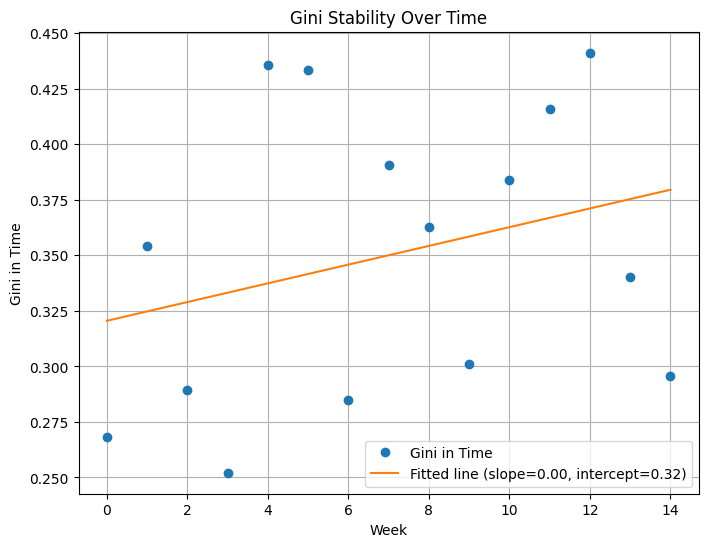

Gini Score of the valid set: 0.3198693852446101


/tmp/ipykernel_33/511156292.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PREDICTIONS'] = oof_preds.copy()
/tmp/ipykernel_33/511156292.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['target'].copy()


Model training - done in 120s
Current Time: 2024-03-21 22:16:53.091484
The notebook was run in debug mode. Number of rows: 11111
(151, 3)
                              feature   gain       split                              features  correlation  valid_percentage
                             WEEK_NUM 3649.0 1114.662109                              WEEK_NUM       -0.116             1.000
                         annuity_780A 7323.0 2181.800781                          annuity_780A       -0.059             1.000
                 applicationscnt_867L 1242.0  313.687500                  applicationscnt_867L        0.054             1.000
                     bankacctype_710L   31.0   11.343750                                   NaN          NaN             0.815
                       birthdate_574D 8017.0 2128.125000                        birthdate_574D        0.288             0.942
               clientscnt12m_3712952L   36.0    7.671875                clientscnt12m_3712952L        0.01

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encounter

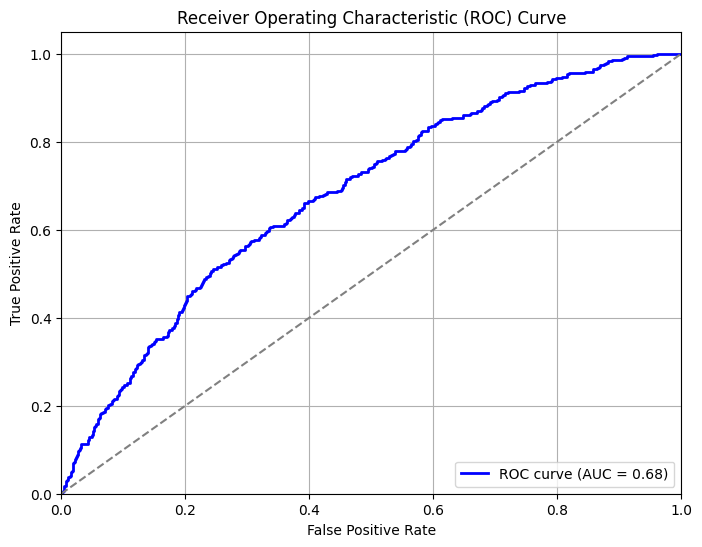

Feature importance assesment - done in 0s


Predicting:   0%|          | 0/10 [00:00<?, ? models/s]

Submission file has been created.
Submission - done in 0s
NOTEBOOK HAS BEEN SUCCESSFULLY EXECUTED !!!
Pipeline total time - done in 197s


In [35]:

if __name__ == "__main__":
    pd.set_option('display.max_rows', 60)
    pd.set_option('display.max_columns', 100)
    with timer("Pipeline total time"):
        main(debug= True)
